In [177]:
#It is a good practice to import all the modules required for training the model.
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Step 1: Downloading and Exploring the Dataset

In [178]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" #The url of the dataset is given here
DATA_FILENAME = "Energyefficiency.csv" #the name of the saved downloaded file.
download_url(DATASET_URL, root='.',filename=DATA_FILENAME) #Don't forget to add the directory(any name where the downloaded file is saved) at the root parameter.

Using downloaded and verified file: ./Energyefficiency.csv


In [179]:
# To read the data from the excel file(.xlsx means excel),we use pandas dataframe where dataframe is like row by column which can be visualized below.
dataframe = pd.read_excel(DATA_FILENAME) 
dataframe.head(5) #It is used to get the first 5 rows of the dataframe.

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [180]:
num_rows = len(dataframe)
print(num_rows)

768


In [181]:
num_cols = sum(1 for i in dataframe.columns)
print(num_cols)

10


In [182]:
input_cols = [i for i in dataframe.columns if(i!='Y1' and i!='Y2')] #the column titles of the input variables
print(len(input_cols))

8


In [183]:
output_cols = ['Y1','Y2'] #the column titles of output/target variable(s)
print(len(output_cols))

2


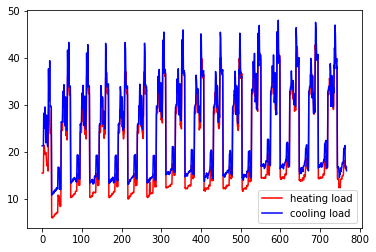

In [184]:
# Visualizing the distribution of target values in a graph.
plt.plot(dataframe['Y1'],'r')
plt.plot(dataframe['Y2'],'b')
plt.legend(['heating load','cooling load'])
plt.show()

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [185]:
import numpy as np
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe as we may need the original one if anything goes wrong which is a good practice.
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outupts as numpy arrays of datatype float32 as the model expects the data to be float instead of double.
    inputs_array = dataframe1[input_cols].to_numpy().astype(np.float32)
    targets_array = dataframe1[output_cols].to_numpy().astype(np.float32)
    return inputs_array, targets_array

In [186]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[9.800e-01, 5.145e+02, 2.940e+02, ..., 2.000e+00, 0.000e+00,
         0.000e+00],
        [9.800e-01, 5.145e+02, 2.940e+02, ..., 3.000e+00, 0.000e+00,
         0.000e+00],
        [9.800e-01, 5.145e+02, 2.940e+02, ..., 4.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [6.200e-01, 8.085e+02, 3.675e+02, ..., 3.000e+00, 4.000e-01,
         5.000e+00],
        [6.200e-01, 8.085e+02, 3.675e+02, ..., 4.000e+00, 4.000e-01,
         5.000e+00],
        [6.200e-01, 8.085e+02, 3.675e+02, ..., 5.000e+00, 4.000e-01,
         5.000e+00]], dtype=float32),
 array([[15.55, 21.33],
        [15.55, 21.33],
        [15.55, 21.33],
        ...,
        [16.44, 17.11],
        [16.48, 16.61],
        [16.64, 16.03]], dtype=float32))

In [187]:
# We should convert the numpy arrays into tensor as the model expects tensors.
inputs = torch.from_numpy(inputs_array)
targets = torch.from_numpy(targets_array)

In [188]:
#let's confirm that the datatype is float
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [189]:
# Let's now create the dataset with inputs and targets combined to create batches at next step
dataset = TensorDataset(inputs, targets)

In [190]:
# It is necessary to split the data into train and validation in order to evaluate the model on untouched data while training the model.
torch.manual_seed(16)#this will make the random same everytime we run this notebook which will help us evaluate a particular value as we do below .
val_percent = 0.1 # between 0.1 and 0.2 is good.
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length.

In [191]:
#Usually we take batch_size as a power of 2(i.e,16,32,64,...) as it improves the speed of the traing convergence(i.e,loss is reduced to minimum soon)
batch_size = 128

In [192]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True) #pin_memory enables the data to be loaded into pinmemory which speedups the GPU loading action.
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True) # num_works are used when the dataset is large to make the loading fat as it is done parallely by 4 systems.

In [193]:
#Let's have a look at the first batch.
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[8.6000e-01, 5.8800e+02, 2.9400e+02,  ..., 5.0000e+00, 1.0000e-01,
         5.0000e+00],
        [7.9000e-01, 6.3700e+02, 3.4300e+02,  ..., 4.0000e+00, 2.5000e-01,
         1.0000e+00],
        [8.6000e-01, 5.8800e+02, 2.9400e+02,  ..., 2.0000e+00, 1.0000e-01,
         5.0000e+00],
        ...,
        [7.9000e-01, 6.3700e+02, 3.4300e+02,  ..., 5.0000e+00, 1.0000e-01,
         3.0000e+00],
        [9.8000e-01, 5.1450e+02, 2.9400e+02,  ..., 4.0000e+00, 1.0000e-01,
         4.0000e+00],
        [7.9000e-01, 6.3700e+02, 3.4300e+02,  ..., 2.0000e+00, 1.0000e-01,
         1.0000e+00]])
targets: tensor([[26.4500, 31.2800],
        [39.8600, 36.8500],
        [27.0300, 25.8200],
        [15.4100, 19.2300],
        [33.2400, 34.5000],
        [25.9800, 26.9600],
        [11.2200, 14.4400],
        [24.2400, 25.1600],
        [12.2900, 15.4000],
        [35.6500, 41.0700],
        [40.7100, 40.6300],
        [32.7200, 33.2300],
        [14.5200, 16.9400],
        [11.4500, 14.86

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment).

In [194]:
input_size = len(input_cols)
output_size = len(output_cols)

In [195]:
class EfficiencyModel(nn.Module):
    def __init__(self):
        super().__init__()
        #input layer
        self.linear1=nn.Linear(input_size,128)  # we have to pass the number of inputs(number of input columns) and the number of hidden units
        #hidden layers
        self.linear2=nn.Linear(128,64) #previous layer hidden units count and the current layers hidden units count
        self.linear3=nn.Linear(64,32) # make sure that the previous layer hidden units count and the current layer hidden units count are equal.
        self.linear4=nn.Linear(32,16)
        self.linear6=nn.Linear(16,8)
        #output layer
        self.linear5=nn.Linear(8,output_size) # here we need to pass previous layers hidden units count and number of outputs(number of output columns) as we mentioned above.
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1) #As the model expects the features to flattened(i.e, all the features are stacked vertically),view()will do this for us where -1 makes the model to rest features as 2nd dimension.
        # Apply layers & activation functions
        out= self.linear1(out) #It is an inbuilt-method for linear regression i.e  z= w*x +b where w is the weight and b is the bias
        out=F.relu(out)  #As we can know from the previous post that linear relation can't make a good prediction , now we are using a non-linear activation function called rectified linear units (Relu)
        out= self.linear2(out)
        out=F.relu(out)
        out= self.linear3(out)
        out=F.relu(out)
        out= self.linear4(out)
        out=F.relu(out)
        out= self.linear6(out)
        out=F.relu(out)
        out=self.linear5(out)  # here we used 5 layers including 3 hidden layers.
        return out
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)  #which returns the predicted values      
        # Calcuate loss
        loss = F.l1_loss(out,targets) #L1 loss(i.e ((1/num_rows)*(predicted-target)^2)^1/2) which is used to calculate the loss. Although there are lot loss functions, l1_loss will be more suitable for linear reg.
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out,targets)                           # l1_loss is calculated for validation set   
        return {'val_loss': loss.detach()}  
        #detach() is used to remove this from computational graph as it may confuse the backprop since it is the loss of validation set to clear the memory whic will make training fast.
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combining losses for all the batches to compute a single loss value
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch where epoch represents a complete traversal through the training examples.
        if (epoch+1) % 2 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch+1, result['loss'],result['val_loss']))

In [196]:
torch.cuda.is_available() #This gives whether the gpu is available or not in form of boolean(true or false)
def get_default_device():
    """To pick GPU if available, else CPU so that the program won't crash if gpu not available"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device=get_default_device()
print(device)
def to_device(data, device):
    """Move tensor(s) to chosen device as everything should be present in the respective device """
    if isinstance(data, (list,tuple)): # isinstance checks whether the input is of the desired type like it is list or tuple and will go next only if the condition is passed.
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True) #thus the data is moved according to the device selected

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device .Don't worry if you dont't get it,just do as instructed"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
#The above class will perform the functions when the instance is called.

cpu


In [197]:
#Let's now create the instances for the below data.
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [198]:
model = to_device(EfficiencyModel(),device) #Initializing the model and also moving the model to the device

In [199]:
#once the model is initialized ,all the w's(weights) and b's(biases) are initialized at random which are then updated by calculating the derivative of the loss fuction with respect to both w and b respectively.
#This is how the model is made to learn the relations between inputs and targets.
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0367,  0.0677, -0.3206,  ...,  0.1509,  0.1255,  0.1303],
         [-0.3017,  0.0399, -0.2497,  ...,  0.1987, -0.0342, -0.0506],
         [-0.1512,  0.2692,  0.2953,  ...,  0.1844,  0.0584,  0.2468],
         ...,
         [-0.2175, -0.0951, -0.1442,  ..., -0.1716,  0.1381,  0.3450],
         [ 0.0923, -0.1492, -0.1850,  ..., -0.1553,  0.2271,  0.0432],
         [ 0.0365,  0.3416, -0.2106,  ...,  0.1370, -0.3194, -0.0408]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.1809,  0.2543,  0.0452, -0.0518,  0.2134, -0.0684, -0.1135,  0.1795,
          0.0195,  0.2496, -0.2400, -0.0900, -0.2915, -0.0143, -0.0323,  0.1547,
         -0.0224, -0.2755,  0.3487,  0.0736, -0.0028, -0.0017, -0.1976, -0.1420,
          0.2680, -0.2550,  0.3529, -0.2832, -0.1856,  0.2673, -0.3534,  0.1571,
          0.2461,  0.2404, -0.1511, -0.1377,  0.0708,  0.2742,  0.2924, -0.2256,
          0.0553, -0.2192,  0.2404, -0.0191, -0.3220, -0.3214,  0.3500, -0.2415

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [200]:
def evaluate(model, val_loader):
    #To evaluate the validation set
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr) #optimizer which is used update the parameters. Stochastic Gradient Descent is mostly used for linear reg. problems.
    for epoch in range(epochs):
        # Training Phase 
        losses=[]
        for batch in train_loader:
            loss = model.training_step(batch)
            losses.append(loss) #the training losses are stored for every batch for future visualizations.
            loss.backward() # Backpropagation(i.e, derivative(slope) calculation) is made by the model.
            optimizer.step() #It updates the weights and biases with the derivatives and learning rate(i.e, w=w-lr*dw)
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['loss']= torch.stack(losses).mean()  #The mean of training losses is stored for each epoch.
        model.epoch_end(epoch, result, epochs)
        history.append(result) #appending the results for visualization purposes.
    return history

In [201]:
result = evaluate(model,val_loader) # Use the the evaluate function to evaluate the model.
print(result)

{'val_loss': 24.13140106201172}


In [216]:
epochs = 150 #number of epochs to run the model.
lr = 0.5e-3  #learning rate
model = to_device(EfficiencyModel(),device)
model.load_state_dict(torch.load("savedmodel/1")) #To load the model and predict
model.eval()
#If you want run comment the above 2 lines and uncomment the below line
#history = fit(epochs, lr, model, train_loader, val_loader)

EfficiencyModel(
  (linear1): Linear(in_features=8, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=16, bias=True)
  (linear6): Linear(in_features=16, out_features=8, bias=True)
  (linear5): Linear(in_features=8, out_features=2, bias=True)
)

{'val_loss': 3.33601450920105}


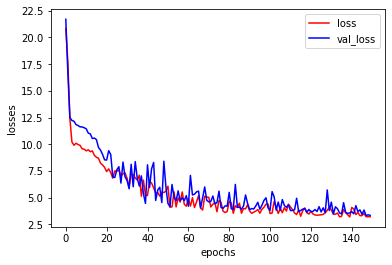

In [217]:
val_loss = evaluate(model,val_loader)
print(val_loss)
#Let's visualize the validation loss for the epochs
plt.plot([i['loss'] for i in history],'r')
plt.plot([i['val_loss'] for i in history],'b')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend(['loss','val_loss'])
plt.show()

In [218]:
def predict_single(input, target, model):
    predictions = model(input.unsqueeze(0))     
    prediction = predictions[0].detach() #detach() is done to remove it from the computational graphs i.e, its dervatives are no longer calculated.
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [219]:
#Let's check the predictions of the model by passing a value from the validation set(you can also try by passing a tensor of your wish as torch.tensor([...]))
print(val_ds[4])
val=DeviceDataLoader(val_ds[4],device) #we have to move the data to the device to avoid errors.
input, target = val
predict_single(input, target, model)

(tensor([9.0000e-01, 5.6350e+02, 3.1850e+02, 1.2250e+02, 7.0000e+00, 5.0000e+00,
        2.5000e-01, 2.0000e+00]), tensor([31.6600, 37.7200]))
Input: tensor([9.0000e-01, 5.6350e+02, 3.1850e+02, 1.2250e+02, 7.0000e+00, 5.0000e+00,
        2.5000e-01, 2.0000e+00])
Target: tensor([31.6600, 37.7200])
Prediction: tensor([31.1077, 32.0516])
